In [1]:
# Import Libraries
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 
import glob
import pickle
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

In [2]:
# Importing Data
# Change this path variable to match where the CSV's reside
path = Path('../../CSV')

In [3]:
# Load the LOW-G Data & Dynamic Rollover Data
with open(f'{path}/low_g.pkl', 'rb') as file:
        df_lg = pickle.load(file)
with open(f'{path}/dynamic_rollover.pkl', 'rb') as file:
        df_dr = pickle.load(file)

In [4]:
#Check the sizes
print(df_lg.shape)
print(df_dr.shape)
print(df_dr.dtypes)
df_dr['Altitude(MSL)'] = df_dr['Altitude(MSL)'].astype(float)

(258905, 20)
(258905, 21)
Altitude(MSL)            object
Altitude(AGL)           float64
Roll Acceleration       float64
Pitch Acceleration      float64
Yaw Acceleration        float64
Roll                    float64
Pitch                   float64
Yaw                     float64
Roll Rate               float64
Pitch Rate              float64
Yaw Rate                float64
Groundspeed             float64
Wind Speed(True)        float64
Sideslip Angle          float64
Gross Weight            float64
Cyclic Pitch Pos-[0]    float64
Cyclic Roll Pos-[0]     float64
Collective Pos-[0]      float64
Pedal Pos               float64
Rotor Torque-[0]        float64
Dynamic Rollover          int64
dtype: object


In [5]:
# First models will be on LOW-G
#Split the dataset into predictors and target variable
x_lg = df_lg.drop(columns=['LOW-G'])
y_lg = df_lg['LOW-G']

In [6]:
# Create the split using the under sampling method
# First apply stratification
X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(x_lg, y_lg, test_size=0.25,
                                                                stratify=y_lg, random_state=42)

In [7]:
# Apply scaling to the training set
scaler = StandardScaler()
scaler.fit(X_train_lg)
X_train_lg = scaler.transform(X_train_lg)
X_test_lg = scaler.transform(X_test_lg)

In [8]:
# Next apply the undersampling technique on the training set
rus = RandomUnderSampler(random_state=42)
x_sampled_lg, y_sampled_lg = rus.fit_resample(X_train_lg, y_train_lg)

In [9]:
# Now run a KNN model with n = 3
classifier_LG1 = KNeighborsClassifier(n_neighbors=3)
classifier_LG1.fit(x_sampled_lg, y_sampled_lg)
y_pred_LG1 = classifier_LG1.predict(X_test_lg)
# check the performance of the model
print(confusion_matrix(y_test_lg, y_pred_LG1))
print(classification_report(y_test_lg, y_pred_LG1))

[[63821   475]
 [    0   431]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     64296
           1       0.48      1.00      0.64       431

    accuracy                           0.99     64727
   macro avg       0.74      1.00      0.82     64727
weighted avg       1.00      0.99      0.99     64727



In [10]:
#Perform a grid search to find the optimal number of neighbors for LOW-G
# Create a ne model to run KNN on
KNN_lg = KNeighborsClassifier()
# create the parameter grid with k ranging from 1 to 50
param_grid = {'n_neighbors' : np.arange(1,50)}
# Run the grid search
KNNlg_gscv = GridSearchCV(KNN_lg, param_grid, cv=5, scoring = 'f1_micro')

In [11]:
#Fit the model to the data
#Will use the undersampled data
KNNlg_gscv.fit(x_sampled_lg, y_sampled_lg)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             scoring='f1_micro')

In [12]:
# The resulting optimal number of neighbors is seen below
print('The optimal number of neighbors for LOW-G is:', KNNlg_gscv.best_params_)

The optimal number of neighbors for LOW-G is: {'n_neighbors': 1}


In [13]:
#The optimal number of neighbors is 1 however that is not flexible enough so 2 will be used
classifier_LG2 = KNeighborsClassifier(n_neighbors=2)
classifier_LG2.fit(x_sampled_lg, y_sampled_lg)
y_pred_LG2 = classifier_LG2.predict(X_test_lg)
# check the performance of the model
print(confusion_matrix(y_test_lg, y_pred_LG2))
print(classification_report(y_test_lg, y_pred_LG2))

[[64007   289]
 [    0   431]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64296
           1       0.60      1.00      0.75       431

    accuracy                           1.00     64727
   macro avg       0.80      1.00      0.87     64727
weighted avg       1.00      1.00      1.00     64727



In [14]:
# Now build a model for dynamic rollover
#Split the dataset into predictors and target variable
x_dr = df_dr.drop(columns=['Dynamic Rollover'])
y_dr = df_dr['Dynamic Rollover']

In [15]:
# Create the split using the under sampling method
# First apply stratification
X_train_dr, X_test_dr, y_train_dr, y_test_dr = train_test_split(x_dr, y_dr, test_size=0.25,
                                                                stratify=y_dr, random_state=42)

In [16]:
# Apply scaling to the training set
scaler = StandardScaler()
scaler.fit(X_train_dr)
X_train_dr = scaler.transform(X_train_dr)
X_test_dr = scaler.transform(X_test_dr)

In [17]:
# Next apply the undersampling technique on the training set
rus = RandomUnderSampler(random_state=42)
x_sampled_dr, y_sampled_dr = rus.fit_resample(X_train_dr, y_train_dr)

In [18]:
# Now run a KNN model with n = 3
classifier_DR1 = KNeighborsClassifier(n_neighbors=3)
classifier_DR1.fit(x_sampled_dr, y_sampled_dr)
y_pred_DR1 = classifier_DR1.predict(X_test_dr)
# check the performance of the model
print(confusion_matrix(y_test_dr, y_pred_DR1))
print(classification_report(y_test_dr, y_pred_DR1))

[[63722   366]
 [    0   639]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     64088
           1       0.64      1.00      0.78       639

    accuracy                           0.99     64727
   macro avg       0.82      1.00      0.89     64727
weighted avg       1.00      0.99      0.99     64727



In [19]:
#Perform a grid search to find the optimal number of neighbors for Dynamic Rollover
# Create a ne model to run KNN on
KNN_dr = KNeighborsClassifier()
# create the parameter grid with k ranging from 1 to 50
param_grid = {'n_neighbors' : np.arange(1,50)}
# Run the grid search
KNNdr_gscv = GridSearchCV(KNN_dr, param_grid, cv=5, scoring = 'f1_micro')

In [20]:
#Fit the model to the data
#Will use the undersampled data
KNNdr_gscv.fit(x_sampled_dr, y_sampled_dr)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             scoring='f1_micro')

In [21]:
# The resulting optimal number of neighbors is seen below
print('The optimal number of neighbors for Dynamic Rollover is:', KNNdr_gscv.best_params_)

The optimal number of neighbors for Dynamic Rollover is: {'n_neighbors': 1}


In [22]:
#The optimal number of neighbors is 1 however that is not flexible enough so 2 will be used
classifier_DR2 = KNeighborsClassifier(n_neighbors=2)
classifier_DR2.fit(x_sampled_dr, y_sampled_dr)
y_pred_DR2 = classifier_DR2.predict(X_test_dr)
# check the performance of the model
print(confusion_matrix(y_test_dr, y_pred_DR2))
print(classification_report(y_test_dr, y_pred_DR2))

[[63857   231]
 [    0   639]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64088
           1       0.73      1.00      0.85       639

    accuracy                           1.00     64727
   macro avg       0.87      1.00      0.92     64727
weighted avg       1.00      1.00      1.00     64727



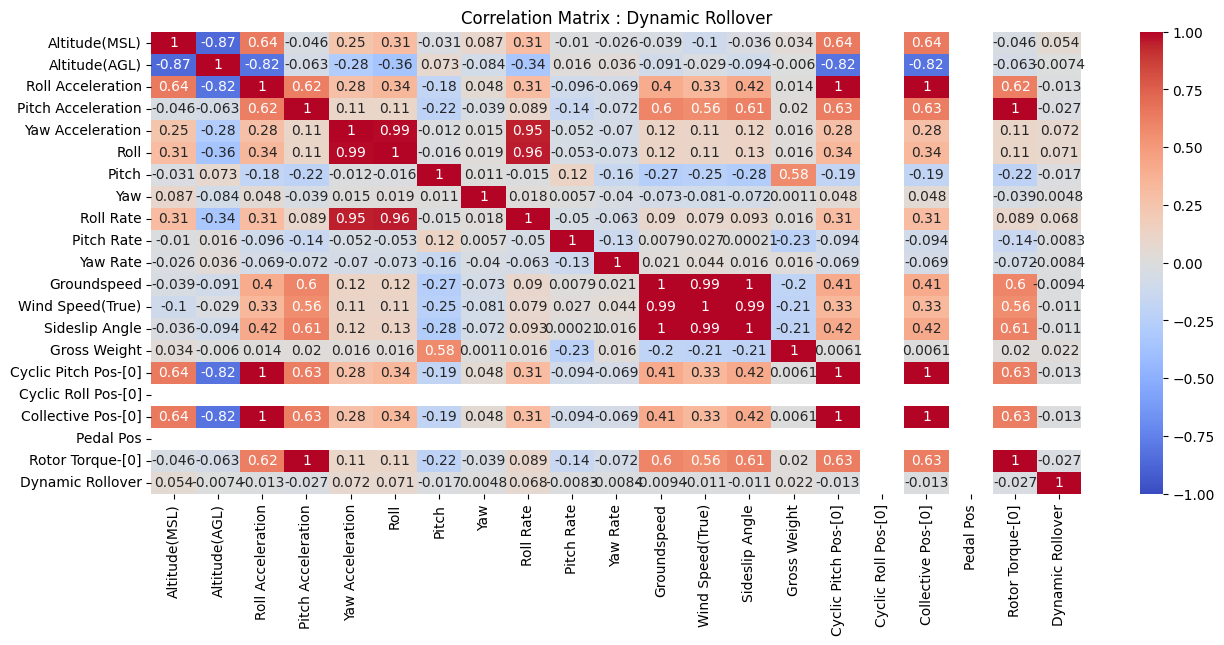

In [23]:
# correlation matrix
correlation_matrix_dr = df_dr.corr()
# heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix_dr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix : Dynamic Rollover')
plt.show()

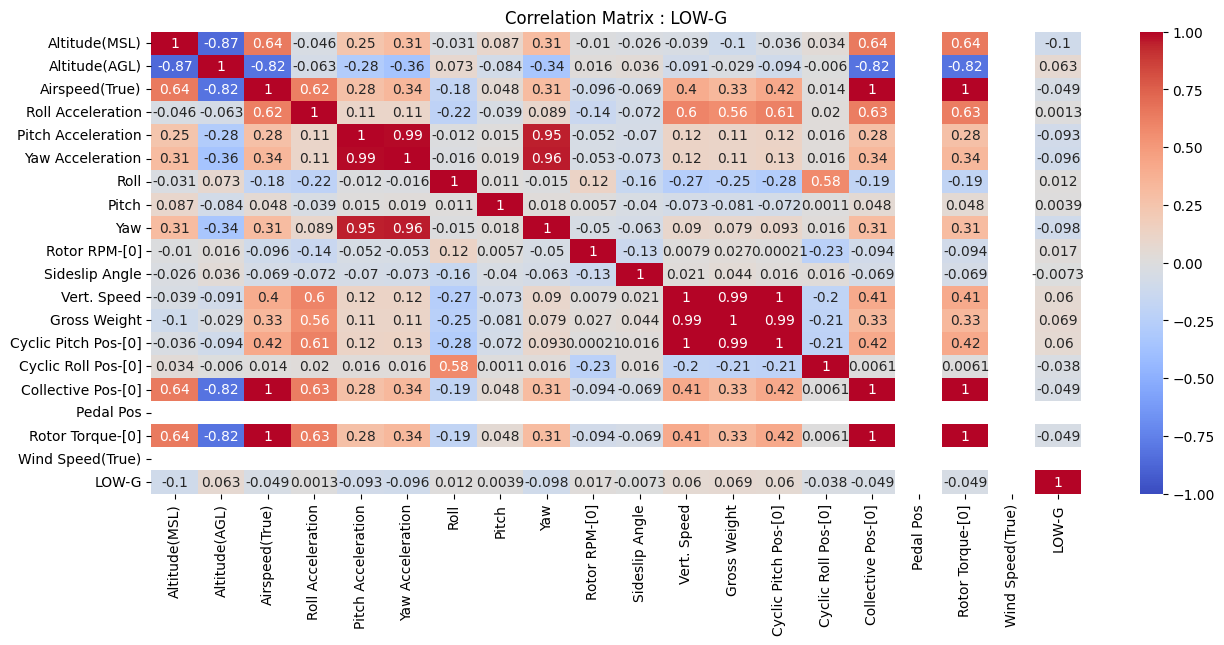

In [24]:
# correlation matrix
correlation_matrix_lg = df_lg.corr()
# heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix_lg, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix : LOW-G')
plt.show()

# Visualizations

In [26]:
import plotly.express as px

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

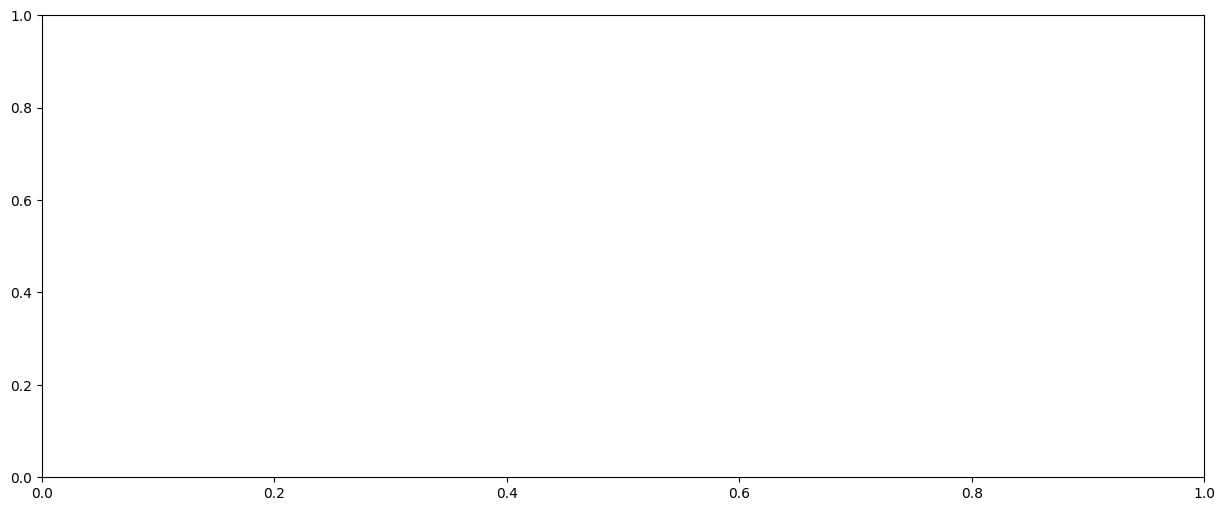

In [27]:
# Create a precision-recall curve for Dynamic Rollover n=2
from sklearn.metrics import precision_recall_curve
y_lg_prob_test = classifier_LG2.predict_proba(X_test_lg)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test_lg, y_lg_prob_test)
plt.figure(figsize=(15, 6))
plt.grid(b = True, color = 'grey',
       linestyle = '-', linewidth = 0.5,
       alpha = 0.2)
plt.fill_between(recall, precision, alpha=0.3)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Dynamic Rollover KNN (N=2) Precision-Recall curve")
no_skill_lg = len(y_test_lg[y_test_lg == 1]) / len(y_test_lg)
plt.plot([0, 1], [no_skill_lg, no_skill_lg], linestyle='--', label='No Skill')
plt.legend()
plt.show()

In [ ]:
# Create a precision-recall curve for Dynamic Rollover n=2
from sklearn.metrics import precision_recall_curve
y_dr_prob_test = classifier_DR2.predict_proba(X_test_dr)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test_dr, y_dr_prob_test)
plt.figure(figsize=(15, 6))
plt.grid(b = True, color = 'grey',
       linestyle = '-', linewidth = 0.5,
       alpha = 0.2)
plt.fill_between(recall, precision, alpha=0.3)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Dynamic Rollover KNN (N=2) Precision-Recall curve")
no_skill_dr = len(y_test_dr[y_test_dr == 1]) / len(y_test_dr)
plt.plot([0, 1], [no_skill_dr, no_skill_dr], linestyle='--', label='No Skill')
plt.legend()
plt.show()